# MCMC for Coin Toss 

In [2]:
# import libraries
try:
  import distrax
except:
  %pip install -qq distrax
  import distrax
try:
    import blackjax
except:
    %pip install -qq blackjax
    import blackjax
import ipywidgets as widgets
import jax
import jax.numpy as jnp
import logging
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import tensorflow as tf
import tensorflow_probability.substrates.jax as tfp
from rmh import rmh_inference_loop,plot_rmh
tfd = tfp.distributions

logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

2022-06-13 16:32:31.209790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


# Model description
<h2>Prior</h2>

$\theta \sim Beta(\alpha,\beta)$

<h2>Likelihood</h2>

$x \sim Bernoulli(\theta)$


In [9]:
def get_data(file_name):
    with open(file_name,'rb') as f:
        all_data = pickle.load(f)
    samples = all_data['data']
    alpha_prior = all_data['prior']['alpha']
    beta_prior = all_data['prior']['beta']
    return samples, alpha_prior, beta_prior
    
def create_log_postfn(samples,alpha_prior,beta_prior):
  prior_beta_dist = tfd.Beta(alpha_prior,beta_prior)
  def log_postfn(x):
    x = x['x']
    prob = jax.nn.sigmoid(x)
    log_prior = prior_beta_dist.log_prob(prob)
    like_bernoulli = tfd.Bernoulli(x)
    log_like = jnp.array([jnp.sum(like_bernoulli.log_prob(samples))])
    return (log_like+log_prior)[0]
  return log_postfn

In [10]:
samples, alpha_prior , beta_prior = get_data("../data/coin_toss/coin_toss")
samples = jnp.array(samples)

Lets get the samples now.

In [16]:
samples,alpha_prior,beta_prior

(DeviceArray([1, 1, 1, 1, 1, 1, 0, 0, 1, 1], dtype=int32), 10, 15)

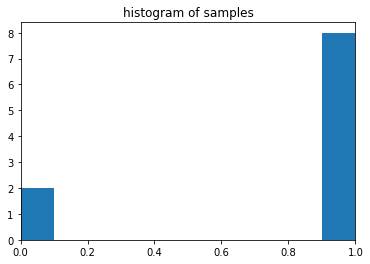

In [17]:
plt.hist(samples)
plt.xlim(0,1)
plt.title("histogram of samples")
plt.show()

In [11]:
log_postfn = create_log_postfn(samples,alpha_prior,beta_prior)
x = {'x':jnp.array([1.])}
log_postfn(x)

DeviceArray(-9.545955, dtype=float32)

RMH here stands for Random walk Metropolis Hastings.
We will use the blackjax implementation of it.

Things we have to do using jax


*   rmh takes the log of posterior pdf and sigma is the walk length parameter. So give them.
*   Then define the initial state of the rmh. This is done by just giving the initial value of whatever we are trying to estimate.




In [35]:
states = rmh_inference_loop(log_postfn,jnp.ones(1)*0.9,x,5000)
states.position['x'] = jax.nn.sigmoid(states.position['x'])

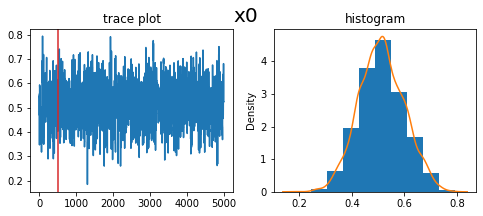

In [36]:
plot_rmh(states,500,contains_arrays=True)

In [33]:
import pickle
with open("../results/coin_toss/MCMC_BlackJAX","wb") as f:
    pickle.dump(states,f)
# plt.hist(jax.nn.sigmoid(states.position[300:,0]),density=True,bins=20)

# Varient 1
alpha = 1, beta = 5

In [14]:
samples, alpha_prior , beta_prior = get_data("../data/coin_toss/coin_toss1")

In [15]:
log_postfn = create_log_postfn(samples,alpha_prior,beta_prior)
x = {'x':jnp.array([1.])}
log_postfn(x)

DeviceArray(-4.776226, dtype=float32)

In [16]:
states = rmh_inference_loop(log_postfn,jnp.ones(1)*0.9,x,5000)
states.position['x'] = jax.nn.sigmoid(states.position['x'])

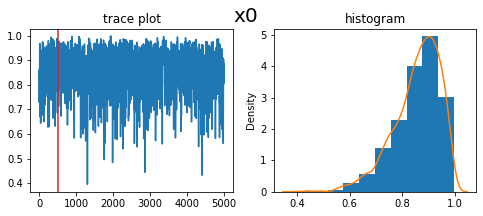

In [19]:
plot_rmh(states,500)

In [20]:
from pandas import to_pickle
to_pickle(states,"../results/coin_toss/MCMC_BlackJAX")

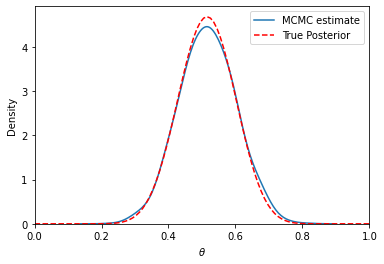